# 1. Kütüphanelerin Tanımlanması

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# 2. Verisetinin Tanıtılması
Veri setinin yolu tanımlanması ve içindeki verilerin ne içerdiğine dair başlıkların görüntülenmesi yapıldı.

In [18]:
directory = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
classes = [i for i in os.listdir(directory) if '.' not in i]
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

# 2.1. Veri Seti Yollarının Verilmesi
Veri setinin içindeki görsellerin veri yolları ve etiketleri bir data isimli bir dataframe'e eklendi.

In [19]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':
            if dir_name.split()[-1]!='GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))
                
data = pd.DataFrame(columns=['path', 'label'])
data['path']=path
data['label']=label

# 3. Etiketlerin Belirlenmesi
**Label Encoder:** Veri setlerinde birden fazla olan kategorik veri etiketlerinin sayısal verilerle ifade edilmesi anlamına gelir. Bu yüzden bu veri setinde etiket isimleri sayısal değerlere çevrilip okunabilmesi için tekrar string verilere çevrildi.

In [10]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
data['label'] = data['label'].astype(str)

# 4. Test ve Eğitim Verilerinin Belirlenmesi
Model eğitimi sırasında modelin doğruluğunu ölçmek için eğitim verilerinin değerlerine göre oluşan tahminleri test verilerine göre kıyasamak için yapılan bir yöntemdir. Bu veri seti için %20 test verisi olarak ayrıldı ve her defasında aynı rastgele ayrılma methoduyla ayrılması için önceden belirlenen bir sayıyla ifade edildi.

Eğitim ve test verileri için ayrılan verilerin miktarları hakkında bilgilendirme verildi.

In [16]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
print(f'Train veri seti boyutu: {len(train_data)}')
print(f'Test veri seti boyutu: {len(val_data)}')

Train veri seti boyutu: 7200
Test veri seti boyutu: 1800


# 5. Veri Üretme

**ImageDataGenerator** methoduyla elimizde olan verilerden daha fazla içerik oluşturup modelin daha fazla bilgiye sahip olmasını sağlanır. Genelleme yeteneğini arttırırken ezberden uzaklaşmasına yardımcı olur.
Özelliklerin fonksiyonları yanlarında belirtilmiştir;

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,         #Normalizasyon: Her bir piksel için 0-1 arasında değerlere çevirir
                                  rotation_range=40,       #0-40 derece arasında rastgele döndürme yapar
                                  width_shift_range=0.15,  #%15 oranında yatayda kaydırma yapar
                                  height_shift_range=0.15, #%15 oranında dikeyde kaydırma yapar
                                  shear_range=0.15,        #Rastgele kesme uygular
                                  zoom_range=0.2,          #520 oranında yakınlaşma uygular
                                  horizontal_flip=True,    #Aynalama yaparak simetri alır
                                  fill_mode='nearest',     #Boş kalan alanları en yakın pikselle doldurur
                                  validation_split=0.2)    #%20 eğitim veri setinden validation için ayırır.

val_datagen = ImageDataGenerator(rescale=1./255)

# 5.1. Eğitim ve Test Verileri Üretme
ImageDataGenerator methoduyla yeni rastgele veriler üretilen veriler modelin eğitimide kullanılmak için aşağıdaki methodla üretilir. Bu method, ImageDataGenerator içindeki okuma methodlarıyla verinin nereden geleceğini ve ne şekilde kullanılacağına dair işlemler yapar.

In [20]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,   # Dataframe'in nereden alınacağı bilgisi
    x_col='path',           # x sütununda ne içereceği
    y_col='label',          # y sütununda ne içereceği
    target_size=(224, 224), # Hedef boyut
    batch_size=32,          # Her defasında aynı anda gönderilecek veri sayısı
    class_mode='sparse',    # Tam sayı değerinde sınıflar belirtir
    subset='training',      # Alt kümenin eğitimde olacağını belirtir
    shuffle=True            # Karıştırma
)

Found 5760 validated image filenames belonging to 9 classes.


In [41]:
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 1440 validated image filenames belonging to 9 classes.


# 6. Model Oluşturma


Veriyi sinir ağına her bir veri için çok boyutlu vermek yerine düzleştirilmiş bir matris olarak vermek boyut uyumsuzluklarını ortadan kaldıracağı için **Flatten** katmanıyla veri düzleştirilerek verildi.

İlk katmandan geçen veri için oluşturulmuş gizli katmanlarda verinin her bir özelliğini daha iyi anlamak ve farklı ağırlıklarla modeli beslemek için belirtilen sayıda nöron eklenerek verinin geçmesi sağlanmıştır. Böylelikle sinir ağından veri geçerken tüm ağırlıkları hesaplanacak ve verinin genellemesini arttırmaya çalışacaktır.
İkinci gizli katmandaysa genelleştirilmiş ve ağırlıkları oluşturulmuş verinin daha net ağırlıklar vermesi amaçlanmıştır ve veri her katmandan geçerken aşırı uyumdan kaçınmak için Dropout ile verinin yarısının geçmesi sağlanmıştır.

Son olarak çıkış katmanında softmax fonksiyonuyla fraklı kategorilerden veri gelebileceği bilgisi verilerek önceden belirttiğimiz 9 farklı kategoriden bilgi beklenmektedir.

**Denemeler sonucu 256-128 ağ yapısı maksimum verimliliği sağlamıştır.**

In [44]:
model = Sequential()

model.add(Flatten(input_shape=(224,224,3)))

model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

# 6.1. Model Derlenmesi
Modelin doğruluğa göre ölçütlerinin oluşturularak her parametre için daha iyi bir öğrenme oranı ayarlayıp sonuçta sayısal bir verinin dönmesini sağlamak amacıyla tasarlanan bir derlemedir. Modelin derleme methodu eğitime verilip istenilen sonuçların dönmesi beklenir.

In [45]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 6.2. Eğitim Sırasındaki Geri Dönüşler
Eğitim sırasında modelin overfit olması durumuna potansiyel durumlarda önceden belirlenen parametreler olduğu takdirde modelin eğitiminin sonlanması anlamına gelir. Bu gibi durumlarda modelin eğitimi sonlandırılarak artık daha iyi sonuç vermeyeceği anlaşılır. Hangi görüntüleme yöntemine göre, kaç epoch sırasında belirtilen parametreler olduğunda duracağı özellikleri verilir.

In [36]:
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=5,
                           restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.keras',
                                  save_best_only=True)

# 6.3. Model Eğitimi
Belirtilen parametreler, test, eğitim verileri verilerek modelin eğitiminin yapılması sağlanır. Verinin ağ üzerinde 10 kez dönmesi gerektiğini söyleyerek eğitim başlatıldı.

In [37]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    callbacks=[early_stop, model_checkpoint])

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1078 - loss: 18.2041

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.1078 - loss: 18.1428 - val_accuracy: 0.1028 - val_loss: 2.1978
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.1086 - loss: 2.1980 - val_accuracy: 0.1000 - val_loss: 2.1981
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.1123 - loss: 2.1980 - val_accuracy: 0.1000 - val_loss: 2.1987
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.1168 - loss: 2.2258 - val_accuracy: 0.1000 - val_loss: 2.1989
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.1151 - loss: 2.1972 - val_accuracy: 0.1000 - val_loss: 2.1990
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.1075 - loss: 2.1972 - val_accuracy: 0.1000 - val_loss: 2.1992
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


# 7. Sonuçların Grafiklendirilmesi

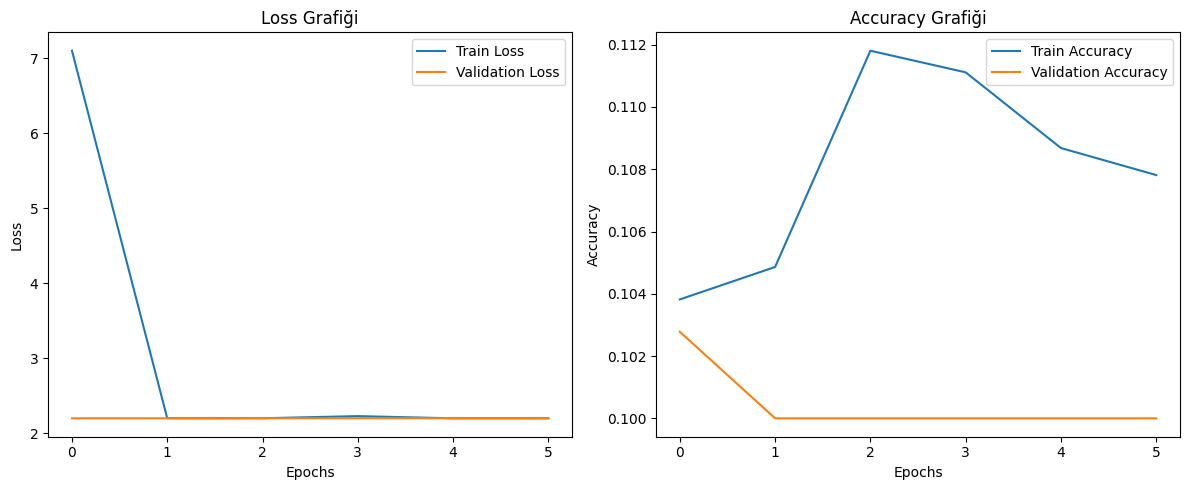

In [38]:
plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()